### Q4. Can you detect cascading failures as delays in one airport create delays in others?

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('airline2_python.db')

In [2]:
c = conn.cursor()

In [3]:
## Since the dataset being used is very big, I'll be using data from only two airports 
c.execute('''SELECT airports.airport as Airport, DepDelay AS DepDelay, ArrDelay AS ArrDelay
FROM ontime JOIN airports ON ontime.Dest = airports.iata
GROUP BY Airport
ORDER BY DepDelay DESC''')

AirportDelay = c.fetchall()

AirportDelay[:5]

[('Marquette County Airport', 167, 158),
 ('Rapid City Regional', 149, 149),
 ('Wiley Post Will Rogers Memorial', 146, 142),
 ('Greenville-Spartanburg', 140, 136),
 ('Santa Barbara Municipal', 138, 137)]

In [4]:
## Since Marquette Country Airport experiences the most delays, i'll be focusing on this airport
c.execute('''SELECT Origin, Dest, CRSDepTime,CRSArrTime, DepTime, ArrTime, DepDelay, ArrDelay
FROM ontime WHERE Origin = 'MQT'
GROUP BY DepDelay
ORDER BY DepDelay DESC''')

MarquetteOri = c.fetchall()

MarquetteOri = pd.DataFrame(MarquetteOri)
MarquetteOri.columns = ['Origin','Dest','CRSDepTime','CRSArrTime','DepTime','ArrTime','DepDelay','ArrDelay']

## Remove cases which have NAs where all of them are in ArrTime as they likely representing flights that have diverted
MarquetteOri = MarquetteOri.dropna()
MarquetteOri[:10]

,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay
0,MQT,ORD,840,855,1945.0,2015.0,665.0,680.0
1,MQT,GRB,630,615,1649.0,1649.0,619.0,634.0
2,MQT,MKE,720,725,1729.0,1842.0,609.0,677.0
5,MQT,ORD,900,920,1538.0,1740.0,398.0,500.0
13,MQT,MSN,755,759,1304.0,1257.0,309.0,298.0
14,MQT,ORD,900,915,1401.0,1417.0,301.0,302.0
15,MQT,ORD,840,855,1333.0,1356.0,293.0,301.0
16,MQT,MKE,720,725,1156.0,1156.0,276.0,271.0
18,MQT,GRB,630,610,1043.0,1029.0,253.0,259.0
19,MQT,ORD,900,915,1312.0,1327.0,252.0,252.0


In [5]:
## Check whether Departure delays in MQT results in Arrival delays for Dest
c.execute('''SELECT Origin, Dest, CRSDepTime,CRSArrTime, DepTime, ArrTime, DepDelay, ArrDelay
FROM ontime WHERE Dest = 'MQT'
GROUP BY ArrDelay
ORDER BY ArrDelay DESC''')

MarquetteDest = c.fetchall()

MarquetteDest = pd.DataFrame(MarquetteDest)
MarquetteDest.columns = ['Origin','Dest','CRSDepTime','CRSArrTime','DepTime','ArrTime','DepDelay','ArrDelay']

## Remove cases which have NAs where all of them are in ArrTime as they likely representing flights that have diverted
MarquetteDest = MarquetteDest.dropna()
MarquetteDest[:10]

,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay
0,MKE,MQT,1955,2150,1553.0,1801.0,1198.0,1211.0
1,GRB,MQT,1835,2015,1310.0,1453.0,1115.0,1118.0
2,GRB,MQT,1835,2015,1021.0,1159.0,946.0,944.0
3,MSN,MQT,1950,2145,745.0,936.0,715.0,711.0
4,MKE,MQT,2005,2200,650.0,847.0,645.0,647.0
5,GRB,MQT,2020,2200,657.0,837.0,637.0,637.0
6,ORD,MQT,1920,2136,2313.0,319.0,233.0,343.0
7,GRB,MQT,1955,2135,118.0,308.0,323.0,333.0
8,ORD,MQT,1810,2028,2307.0,148.0,297.0,320.0
9,GRB,MQT,1955,2130,102.0,246.0,307.0,316.0


In [6]:
MarquetteOriDest = pd.merge(MarquetteOri, MarquetteDest, how='inner', left_on='Dest', right_on='Origin')

MarquetteOriDest = MarquetteOriDest.loc[(MarquetteOriDest["Dest_x"] == "ORD")]
# Keeping only flights between MQT and ORD

### Hierarchical Clustering

In [7]:
MarquetteOriDest.drop(['Origin_x', 'Dest_x','Origin_y','Dest_y'], inplace=True, axis = 1)

list(MarquetteOriDest)

['CRSDepTime_x',
 'CRSArrTime_x',
 'DepTime_x',
 'ArrTime_x',
 'DepDelay_x',
 'ArrDelay_x',
 'CRSDepTime_y',
 'CRSArrTime_y',
 'DepTime_y',
 'ArrTime_y',
 'DepDelay_y',
 'ArrDelay_y']

In [8]:
from sklearn.preprocessing import scale
from pandas import DataFrame

MqOriDest_scaled = DataFrame(scale(MarquetteOriDest), index=MarquetteOriDest.index, columns=MarquetteOriDest.columns)
# Scaled function

In [9]:
clustdf_t = MqOriDest_scaled.transpose()

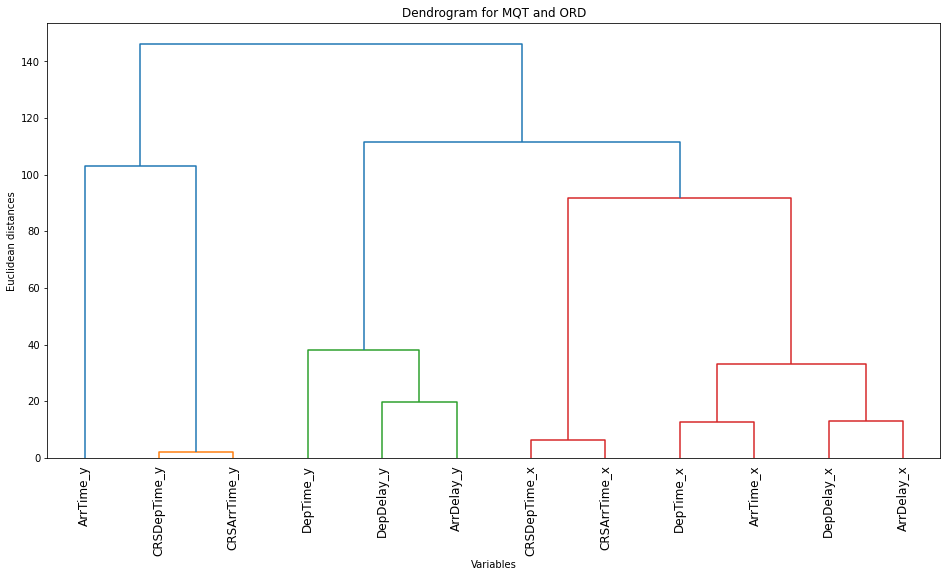

In [10]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import random
random.seed(2022)

plt.figure(1, figsize = (16 ,8))

c_dist = pdist(clustdf_t) # Distance
c_link = linkage(clustdf_t, method='complete')# Linkage

hc = dendrogram(c_link, labels = MqOriDest_scaled.columns)

plt.title('Dendrogram for MQT and ORD')
plt.xlabel('Variables')
plt.ylabel('Euclidean distances')
plt.xticks(rotation='vertical')
plt.show()

## 2 Main Clusters with Arr/Dep Delay in the second airport being in the same cluster Arr/Dep Delay in the first airport
## To further summarise the data, I will be performing K-means clustering to find out how significant Arr/Dep Delay in the first airport
## are as differentiators for the Arr/Dep Delay in the second airport.

### K-means clustering

In [11]:
from sklearn.cluster import KMeans

mq_km = KMeans(n_clusters=2, init='k-means++').fit(MqOriDest_scaled)


In [12]:
mq_kmR = MarquetteOriDest
mq_kmR = mq_kmR.drop(['CRSDepTime_x','CRSArrTime_x','CRSDepTime_y','CRSArrTime_y'], axis=1)

In [13]:
from collections import Counter
Counter(mq_km.labels_)

Counter({1: 3720, 0: 2511})

In [14]:
mq_kmR['Cluster'] = mq_km.labels_

In [15]:
## I will first separate the delays in differing groups in terms of how long the delay is
## No Delays =< 10, Short Delay > 10 & =< 60, Medium Delay > 60 & =< 150, Long Delay > 150

import numpy as np
delaybreaks = [-25, 10, 60, 150, np.inf]
delaylabels = ["Not Delayed", "Short Delay", "Medium Delay", "Long Delay"]

mq_kmR['ArrDelay_y'] = pd.cut(mq_kmR['ArrDelay_y'], delaybreaks, labels=delaylabels)
mq_kmR['DepDelay_y'] = pd.cut(mq_kmR['DepDelay_y'], delaybreaks, labels=delaylabels)
mq_kmR

,DepTime_x,ArrTime_x,DepDelay_x,ArrDelay_x,DepTime_y,ArrTime_y,DepDelay_y,ArrDelay_y,Cluster
0,1945.0,2015.0,665.0,680.0,2313.0,319.0,Long Delay,Long Delay,1
1,1945.0,2015.0,665.0,680.0,2307.0,148.0,Long Delay,Long Delay,1
2,1945.0,2015.0,665.0,680.0,2249.0,123.0,Long Delay,Long Delay,1
3,1945.0,2015.0,665.0,680.0,2259.0,112.0,Long Delay,Long Delay,1
4,1945.0,2015.0,665.0,680.0,2144.0,26.0,Long Delay,Long Delay,1
...,...,...,...,...,...,...,...,...,...
6226,655.0,723.0,-16.0,-9.0,1920.0,2126.0,Not Delayed,Not Delayed,0
6227,655.0,723.0,-16.0,-9.0,1918.0,2125.0,Not Delayed,Not Delayed,0
6228,655.0,723.0,-16.0,-9.0,1915.0,2123.0,Not Delayed,Not Delayed,0
6229,655.0,723.0,-16.0,-9.0,1913.0,2122.0,Not Delayed,Not Delayed,0


In [16]:
## How ArrDelay.X affects Dep/Arr Delays on the second airport
## If Arr/DepDelay.x > 60, count as a delay has occured since a delay of an hour in the initial airport will much more 
## clearly showcase cascading delays for flights following after it

mq_kmR['ArrDelay_x'] = np.where((mq_kmR.ArrDelay_x >= 60), 'Delayed', 'Not Delayed')
mq_kmR['DepDelay_x'] = np.where((mq_kmR.DepDelay_x >= 60), 'Delayed', 'Not Delayed')
mq_kmR

,DepTime_x,ArrTime_x,DepDelay_x,ArrDelay_x,DepTime_y,ArrTime_y,DepDelay_y,ArrDelay_y,Cluster
0,1945.0,2015.0,Delayed,Delayed,2313.0,319.0,Long Delay,Long Delay,1
1,1945.0,2015.0,Delayed,Delayed,2307.0,148.0,Long Delay,Long Delay,1
2,1945.0,2015.0,Delayed,Delayed,2249.0,123.0,Long Delay,Long Delay,1
3,1945.0,2015.0,Delayed,Delayed,2259.0,112.0,Long Delay,Long Delay,1
4,1945.0,2015.0,Delayed,Delayed,2144.0,26.0,Long Delay,Long Delay,1
...,...,...,...,...,...,...,...,...,...
6226,655.0,723.0,Not Delayed,Not Delayed,1920.0,2126.0,Not Delayed,Not Delayed,0
6227,655.0,723.0,Not Delayed,Not Delayed,1918.0,2125.0,Not Delayed,Not Delayed,0
6228,655.0,723.0,Not Delayed,Not Delayed,1915.0,2123.0,Not Delayed,Not Delayed,0
6229,655.0,723.0,Not Delayed,Not Delayed,1913.0,2122.0,Not Delayed,Not Delayed,0


In [17]:
Cluster1 = mq_kmR.loc[mq_kmR['Cluster']==1]
Cluster1.reset_index(inplace=True)

In [18]:
Cluster2 = mq_kmR.loc[mq_kmR['Cluster']==0]
Cluster2.reset_index(inplace=True)

In [19]:
pd.options.mode.chained_assignment = None

In [20]:
Cluster1['ArrDelay_y'] = Cluster1['ArrDelay_y'].astype('category')
Cluster1['DepDelay_y'] = Cluster1['DepDelay_y'].astype('category')
Cluster1['ArrDelay_x'] = Cluster1['ArrDelay_x'].astype('category')
Cluster1['DepDelay_x'] = Cluster1['DepDelay_x'].astype('category')

Cluster2['ArrDelay_y'] = Cluster2['ArrDelay_y'].astype('category')
Cluster2['DepDelay_y'] = Cluster2['DepDelay_y'].astype('category')
Cluster2['ArrDelay_x'] = Cluster2['ArrDelay_x'].astype('category')
Cluster2['DepDelay_x'] = Cluster2['DepDelay_x'].astype('category')



In [21]:
## Comparison of results in Cluster 1

print(Cluster1['DepDelay_y'].value_counts())
print(Cluster1['ArrDelay_y'].value_counts())

## Both cluster results are similar where there is a lot more medium and long delays

Medium Delay    1480
Long Delay       880
Not Delayed      760
Short Delay      600
Name: DepDelay_y, dtype: int64
Medium Delay    1400
Long Delay       960
Short Delay      720
Not Delayed      640
Name: ArrDelay_y, dtype: int64


In [22]:
Cluster1['DepDelay_x'].value_counts(normalize=True) * 100

## Numbers represented in the output are the percentages of that particular variable 
## Cluster 1 has a majority of flights that are do not have any DepDelay in the first airport however it still resulted in there being a 
## lot of medium and long Dep/Arr delays in the second airport which would mean that DepDelays in the first airport do not necessarily lead to cascading delays

Delayed        92.5
Not Delayed     7.5
Name: DepDelay_x, dtype: float64

In [23]:
Cluster1['ArrDelay_x'].value_counts(normalize=True) * 100

## Numbers represented in the output are the percentages of that particular variable
## ArrDelays in Cluster 1 also follow a similar trend to DepDelays which further enforces the idea that Dep/Arr Delays in the first airport do not 
## necessarily result in cascading delays

Delayed        87.5
Not Delayed    12.5
Name: ArrDelay_x, dtype: float64

In [24]:
## Comparison of results in Cluster 2

print(Cluster2['DepDelay_y'].value_counts())
print(Cluster2['ArrDelay_y'].value_counts())

## Both cluster results are similar to cluster 1 where there is a lot more medium and long delays

Medium Delay    999
Long Delay      594
Not Delayed     513
Short Delay     405
Name: DepDelay_y, dtype: int64
Medium Delay    945
Long Delay      648
Short Delay     486
Not Delayed     432
Name: ArrDelay_y, dtype: int64


In [25]:
Cluster2['DepDelay_x'].value_counts(normalize=True) * 100

Not Delayed    85.185185
Delayed        14.814815
Name: DepDelay_x, dtype: float64

In [26]:
Cluster2['ArrDelay_x'].value_counts(normalize=True) * 100

## Although cluster 2 aligns well into the idea that delays in the first airport can result in cascading delays, 
## it does not help cluster 1's case hence i will be leaning more into the idea that you cannot detect cascading delays whereby delays in one airport 
## creates delays in others at least that is the case for flights between MQT and ORD. This is also due to the idea that the delays in the second airport could be
## a result of other various third-party interference as compared to being a correlation to delays in the initial airport.

Not Delayed    88.888889
Delayed        11.111111
Name: ArrDelay_x, dtype: float64